In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sys

sys.path.extend(
    [
        'flock',
        'flock-web',
        'flock-conf',
        'src/poultry',
    ]
)

In [5]:
import os
from urllib.parse import urlparse, parse_qs

import sqlalchemy as sa
from sqlalchemy.orm import sessionmaker

import pandas as pd

from flock import model
from flock_web import model as fw_model

# import graph_tool as gt
# import graph_tool.draw
# import graph_tool.collection

In [6]:
engine = sa.create_engine('postgresql://dnm11:{}@129.6.101.99:15432/twitter'.format(os.environ['DB_PASS']), echo=False)
conn = engine.connect()
model.metadata.bind = engine

Session = sessionmaker(bind=engine)
session = Session()

In [ ]:
sa.b

In [42]:
with session.begin_nested():
    user_actions = pd.DataFrame(
        [
            (
                a.id, a.timestamp, a.user_id, a.endpoint, a.view_args, a.collection,
                a.request_args, a.request_form, a.headers.get('Referer'), a.url,
                #a.url, a.headers.get('Referer'), a.endpoint,
                # a.request_args['q'][0],
                #'on' in a.request_args.get('show_images', []),
                #'pmi' in a.request_args.get('filter', []),
            )
            for a in (
                session
                .query(fw_model.UserAction)
#                 .filter(fw_model.UserAction.url != None)
#                 .filter(fw_model.UserAction.endpoint == 'collection.tweets')
                .filter(sa.between(fw_model.UserAction.user_id, 5, 10))
                .filter(fw_model.UserAction.timestamp > '2017-06-12')
                .order_by(fw_model.UserAction.timestamp)
            )
        ],
        columns=(
            'action_id', 'timestamp', 'user_id', 'endpoint', 'view_args', 'colelction',
            'request_args', 'request_form', 'referer_header', 'url',
                 #'query',
                 #'show_images',
                 #'filter',
                ),
    ).set_index('action_id', drop=False)

In [52]:
def sanitize_request_form(request_form):
    if 'first_name' in request_form:
        request_form['first_name'] = '***'
    return request_form

user_actions['request_form'] = user_actions['request_form'].apply(sanitize_request_form)

In [131]:
user_actions['endpoint'].value_counts()

main.relevance        6358
collection.tweets     2750
main.welcome           514
collection.index       484
main.topic             481
main.topic_post        452
main.topics            163
collection.cluster     124
main.login              37
main.logout             25
Name: endpoint, dtype: int64

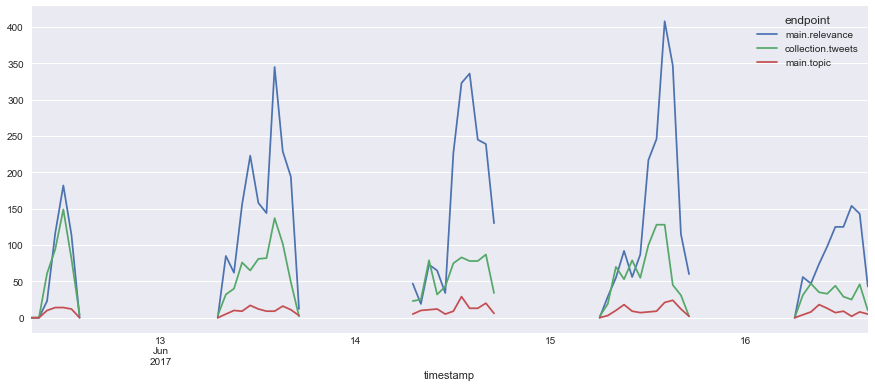

In [141]:
endpoint_activity = user_actions[['timestamp', 'endpoint']].set_index('timestamp')
endpoint_activity['frequency'] = 1
endpoint_activity = endpoint_activity.set_index('endpoint', append=True)
endpoint_activity = endpoint_activity.unstack('endpoint').fillna(0)['frequency']

endpoint_activity = x.resample('1h').sum()[
    [
        'main.relevance',
        'collection.tweets',
        'main.topic',
    ]
]

plt = endpoint_activity.plot(figsize=(15, 6))
plt.figure.savefig('/home/dnm11/Desktop/endpoint_activity.pdf')

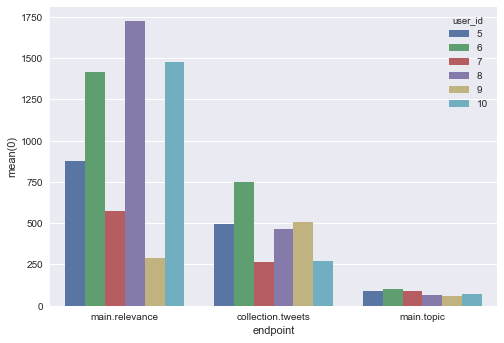

In [203]:
user_activity = user_actions[['user_id', 'endpoint']].groupby(by=['user_id', 'endpoint']).size().reset_index()

plt = sns.barplot(
    data=x, x='endpoint', y=0, hue='user_id',
    order=[
        'main.relevance',
        'collection.tweets',
        'main.topic',
    ],
)

plt.figure.savefig('/home/dnm11/Desktop/user_activity.pdf')

In [211]:
(user_actions.loc[user_actions['endpoint'] == 'main.relevance', 'request_form']).apply(lambda r: r['judgment'][0]).value_counts()

1     4638
-1    1668
0       52
Name: request_form, dtype: int64

In [ ]:
graph = gt.Graph()

vertex_label = graph.new_vertex_property('string')
edge_label = graph.new_edge_property('string')

vertices = {}
# for url in user_actions['url']:
#     v = graph.add_vertex()
#     vertex_label[v] = url
#     vertices[url] = v

for id_, url, referer, q in user_actions[['id', 'url', 'referer', 'query']].values:
    if id_ in [8652, 8846]:
        continue

    if not referer:
        continue

    referer = parse_qs(urlparse(referer).query).get('q', [''])[0]
    if referer not in vertices:
        v_ref = graph.add_vertex()
        vertices[referer] = v_ref
        vertex_label[v_ref] = referer
    else:
        v_ref = vertices[referer]

    url = parse_qs(urlparse(url).query).get('q', [''])[0]
    if url not in vertices:
        v_url = graph.add_vertex()
        vertex_label[v_url] = url
        vertices[url] = v_url
        vertex_label[v_url] = url
    else:
        v_url = vertices[url]
        
    if v_ref is not v_url:
        e = graph.add_edge(
            v_ref, v_url
        )

        edge_label[e] = str(id_)
    

plt.switch_backend('cairo')
fig = plt.figure()
fig.set_size_inches((8.5 * 2, 11 * 2))

pos = gt.draw.sfdp_layout(graph)
gt.draw.graph_draw(
    graph,
    pos=pos,
    mplfig=fig,
    vertex_text_position=0,
#     vertex_text=graph.vertex_index,
    vertex_text=vertex_label,
#     vertex_font_size=7,
    edge_text=edge_label,
    edge_font_size=5,
    output_size=(8.5 * 2, 11 * 2),
)

fig.savefig('/home/dnm11/Desktop/session.pdf')
fig